In [1]:
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

import jax

from src.simulate_trace import MakeTrace, apply_noise, GaussianAmplitude, PolynomialPhase, MultiPulse, RandomPhase

In [2]:
# real fields issues
# classical running but not converging
# general not running -> missing methods, also wrong population shape (because of wrong mro -> create initial stuff is not overwritten)
#       -> works now for frog DifferentialEvolution

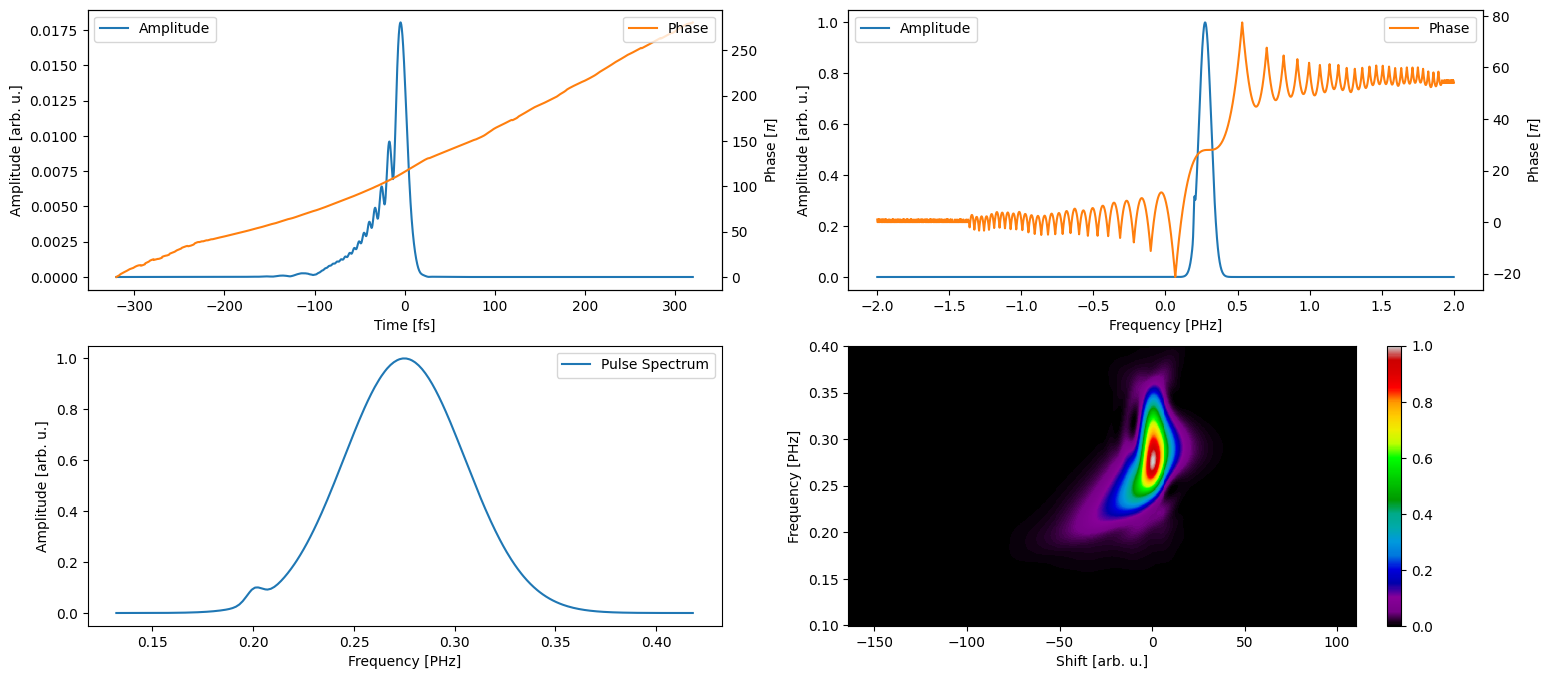

In [3]:

pulse_maker = MakeTrace(N=128*20, Delta_f=2)

central_f = 0.275
phase = PolynomialPhase(0.3, (0,0,0,50))
amp = GaussianAmplitude((1,0.1), (0.275,0.2), (0.1,0.01))
time_inp, pulse_t_inp, frequency_inp, pulse_f_inp = pulse_maker.generate_pulse((amp, phase))


input_pulses = pulse_maker.pulses



central_f = 0.4
phase = PolynomialPhase(central_frequency = central_f, coefficients = np.array([0, 0, -250]))
amp = GaussianAmplitude(central_frequency = central_f, amplitude = 1.0, fwhm = 0.05)
_, _, frequency_gate, pulse_f_gate = pulse_maker.generate_pulse((amp, phase))


delay, frequency, trace, spectra=pulse_maker.generate_frog(time_inp, frequency_inp, pulse_t_inp, pulse_f_inp, "pg", cross_correlation=False, interferometric=False,
                                                          gate=(frequency_gate, pulse_f_gate), real_fields=False, interpolate_fft_conform=False,
                                                          N=128*4, scale_time_range=1.5, plot_stuff=True, cut_off_val=0.0001, frequency_range=(0.1,0.4))

In [4]:
from src.real_fields.frog.classical_algorithms_frog_real_fields import GeneralizedProjection#COPRA#PtychographicIterativeEngine
#from src.real_fields.frog.general_algorithms_frog_real_fields import AutoDiff, DifferentialEvolution

import optax

from src.frog import PtychographicIterativeEngine
#from src.core.construct_s_prime import calculate_S_prime_projection

In [5]:
de = PtychographicIterativeEngine(delay, frequency, trace, "pg", cross_correlation=False)#, f_range_fields=(0.1,0.4))

population = de.create_initial_population(3, "random")

#de.solver = optax.adam(learning_rate=1e-1)

de.local_gamma = 1e-1
de.global_gamma = 1e-1

final_result = de.run(population, 50, 50)

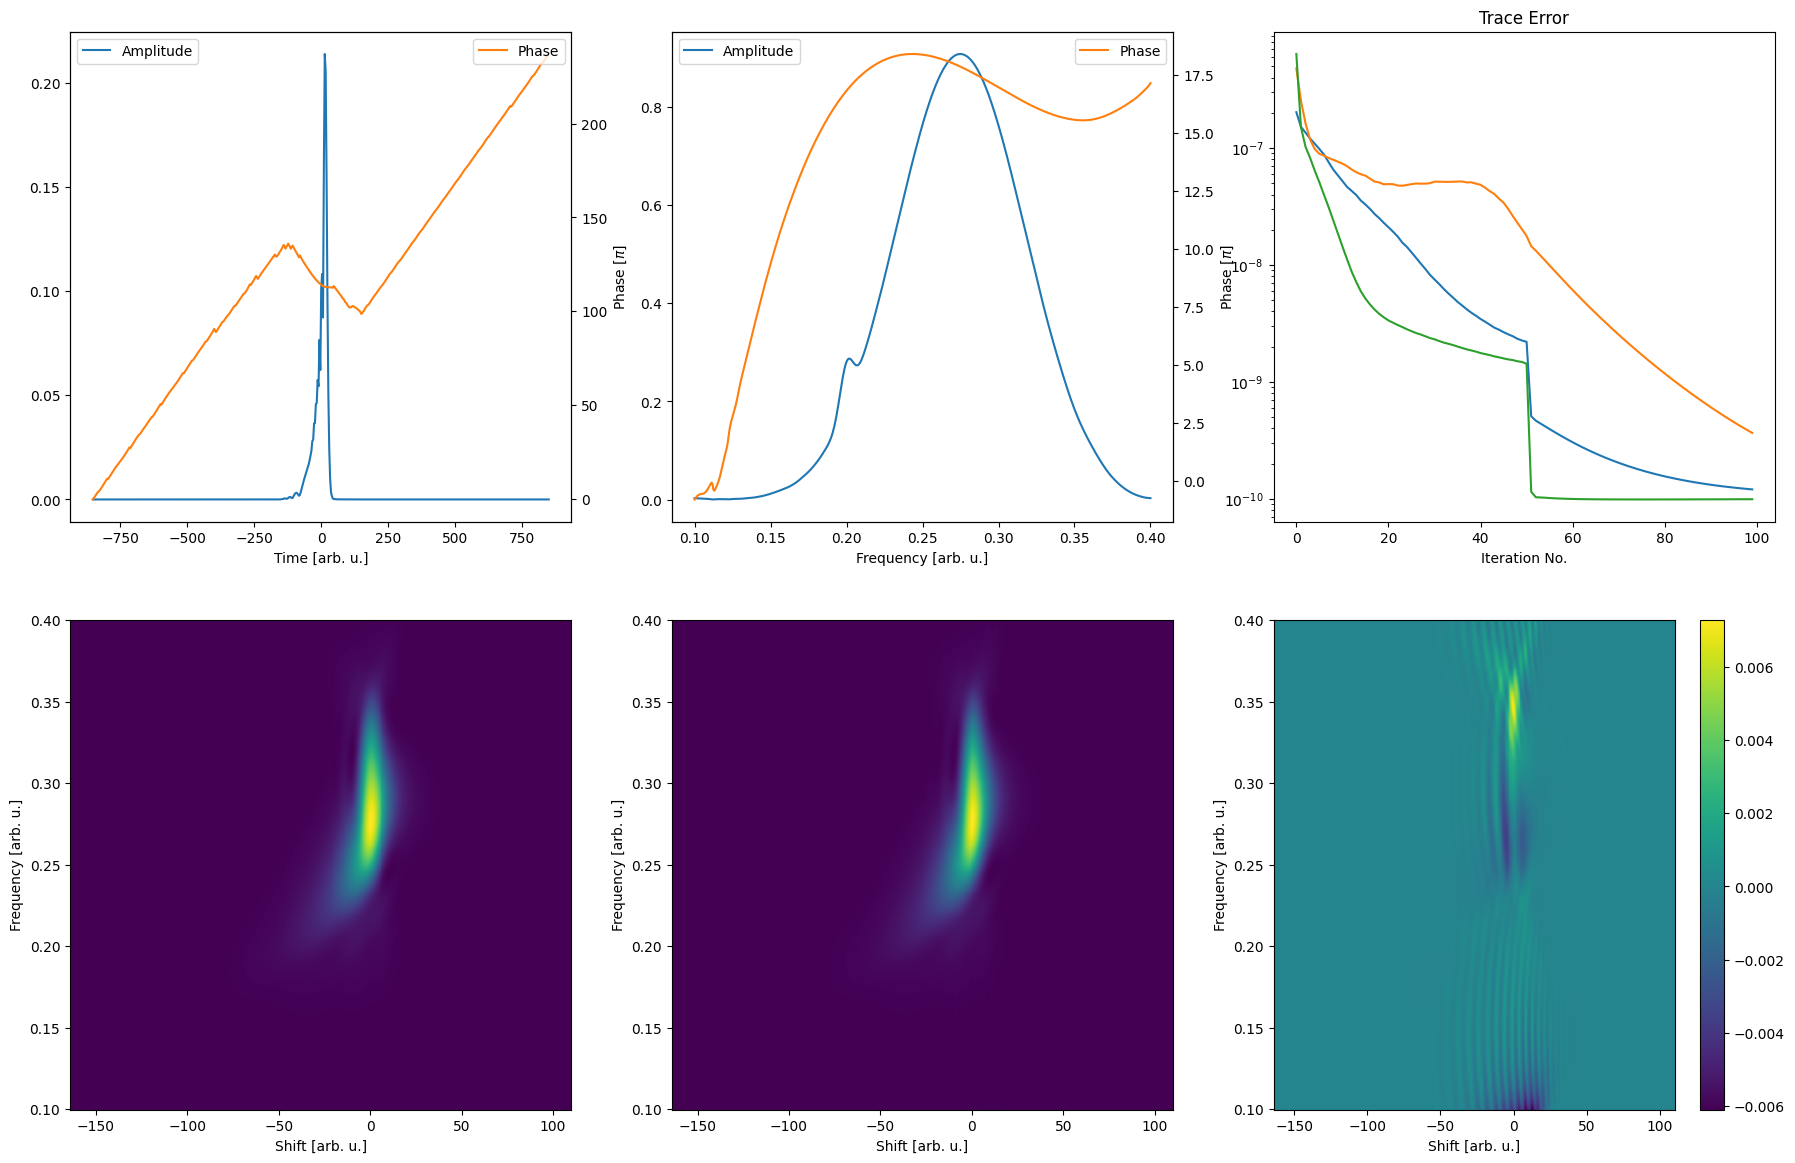

In [6]:
de.plot_results(final_result)

In [7]:
de.descent_info

MyNamespace(measured_spectrum_is_provided: MyNamespace(pulse: [False, bool], gate: [False, bool]), population_size: [3, int], alpha: [1.0, float], gamma: MyNamespace(_local: [0.1, float], _global: [0.1, float]), pie_method: [rPIE, str], conjugate_gradients: [False, bool], newton: MyNamespace(_local: [False, bool], _global: [False, bool], linalg_solver: [lineax, str], lambda_lm: [0.001, float], lbfgs_memory: [10, int]), linesearch_params: MyNamespace(linesearch: [False, bool], c1: [0.0001, float], c2: [0.9, float], max_steps: [15, int], delta_gamma: [0.5, float]), s_prime_params: MyNamespace(_local: [projection, str], _global: [projection, str], number_of_iterations: [1, int], r_gradient: [intensity, str], r_newton: [False, bool], weights: [1.0, float]), xi: [1e-12, float], adaptive_scaling: MyNamespace(_local: [False, bool], _global: [False, bool]))

In [8]:
from src.core.construct_s_prime import calculate_S_prime_projection

In [9]:
signal_t = de.generate_signal_t(de.descent_state, de.measurement_info, de.descent_info)
signal_t_new = calculate_S_prime_projection(signal_t.signal_f, de.measurement_info.measured_trace, 1, de.measurement_info)
transform_arr = jnp.broadcast_to(de.measurement_info.transform_arr, (3,128))
measured_trace = jnp.broadcast_to(de.measurement_info.measured_trace, (3,128,128))

TypeError: calculate_S_prime_projection() missing 1 required positional argument: 'rn'

In [ ]:
grad, U = de.calculate_PIE_descent_direction(population, signal_t, signal_t_new, transform_arr, measured_trace, , de.measurement_info, de.descent_info, "pulse")

SyntaxError: invalid syntax (3464244470.py, line 1)

In [ ]:
grad.shape, U.shape

((3, 1, 128), (3, 128, 128))

In [ ]:
d = jnp.sum(grad*U, axis=1)

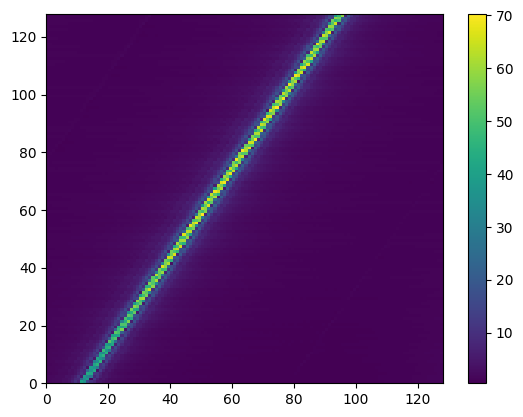

In [ ]:
plt.pcolormesh(jnp.abs(U[0]))
plt.colorbar()

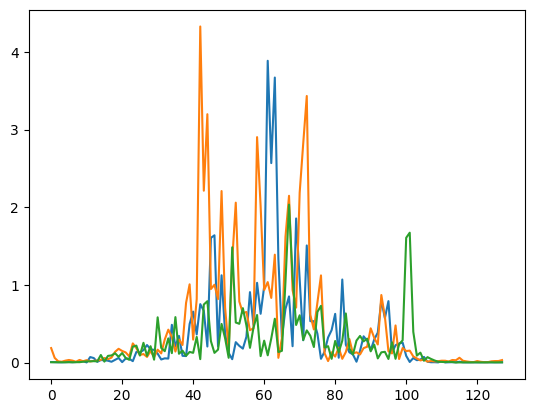

In [ ]:
plt.plot(jnp.abs(d.T))

ValueError: not enough values to unpack (expected 2, got 1)

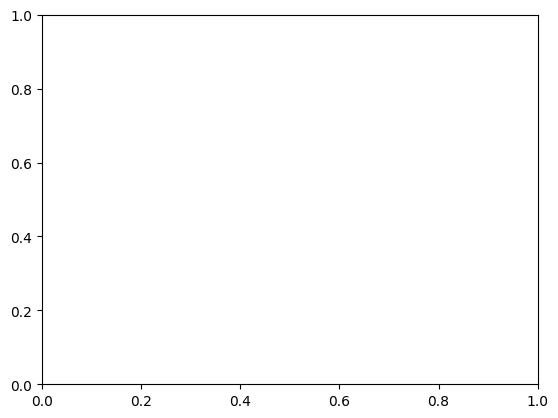

In [ ]:
plt.pcolormesh(jnp.abs(d[2]))

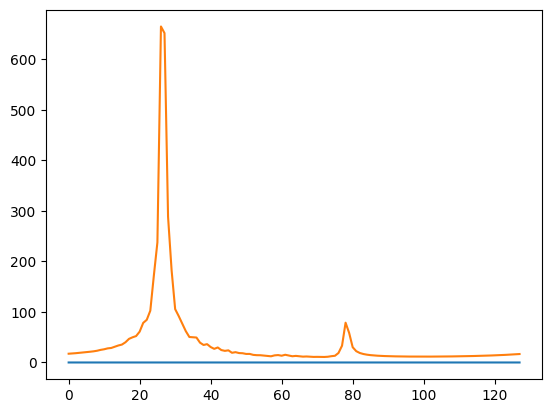

In [ ]:
plt.plot(jnp.abs(res[0][0,0]))
plt.plot(jnp.abs(res[1][0,0]))